# Method 1

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models

import scipy.io

In [2]:
IMG_DIR = './jpg'
LABEL_FILE = './imagelabels.mat'
SETID_FILE = './setid.mat'

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

labels = scipy.io.loadmat(LABEL_FILE)['labels'][0] - 1
setids = scipy.io.loadmat(SETID_FILE)
train_ids = setids['trnid'][0] - 1
val_ids = setids['valid'][0] - 1
test_ids = setids['tstid'][0] - 1

print(f"Total images: {len(labels)}")
print(f"Train: {len(train_ids)}, Val: {len(val_ids)}, Test: {len(test_ids)}")

Total images: 8189
Train: 1020, Val: 1020, Test: 6149


In [4]:
class SimCLRTransform:
    def __init__(self, image_size=224):
        self.transform = T.Compose([
            T.RandomResizedCrop(image_size),
            T.RandomHorizontalFlip(),
            T.ColorJitter(0.8, 0.8, 0.8, 0.2),
            T.RandomGrayscale(p=0.2),
            T.GaussianBlur(kernel_size=9),
            T.ToTensor(),
            T.Normalize((0.5,), (0.5,))
        ])

    def __call__(self, x):
        xi = self.transform(x)
        xj = self.transform(x)
        return xi, xj

In [5]:
class FlowerSimCLRDataset(Dataset):
    def __init__(self, img_dir, indices, transform):
        self.img_dir = img_dir
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img_id = self.indices[idx] + 1
        img_path = os.path.join(self.img_dir, f'image_{img_id:05d}.jpg')
        image = Image.open(img_path).convert("RGB")
        return self.transform(image)

In [6]:
class SimCLR(nn.Module):
    def __init__(self, base_encoder='resnet18', projection_dim=128):
        super(SimCLR, self).__init__()

        resnet = models.__dict__[base_encoder](pretrained=False)
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])  # 去掉fc层

        feat_dim = resnet.fc.in_features

        self.projector = nn.Sequential(
            nn.Linear(feat_dim, feat_dim),
            nn.ReLU(),
            nn.Linear(feat_dim, projection_dim)
        )

    def forward(self, x):
        h = self.encoder(x)
        h = h.squeeze()
        z = self.projector(h)
        z = F.normalize(z, dim=1)
        return z

In [7]:
def nt_xent_loss(z_i, z_j, temperature=0.5):
    batch_size = z_i.shape[0]
    device = z_i.device

    z = torch.cat([z_i, z_j], dim=0)
    z = F.normalize(z, dim=1)

    similarity_matrix = torch.matmul(z, z.T)

    labels = torch.cat([
        torch.arange(batch_size, 2 * batch_size),
        torch.arange(0, batch_size)
    ]).to(device)

    mask = torch.eye(2 * batch_size, dtype=torch.bool).to(device)
    similarity_matrix = similarity_matrix.masked_fill(mask, -1e9)

    similarity_matrix = similarity_matrix / temperature

    loss = F.cross_entropy(similarity_matrix, labels)
    return loss


In [8]:
def train_simclr(model, dataloader, optimizer, device, epochs=10):
    model.train()
    model.to(device)

    for epoch in range(epochs):
        total_loss = 0
        for step, (xi, xj) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}")):
            xi, xj = xi.to(device), xj.to(device)

            try:
                zi = model(xi)
                zj = model(xj)

                loss = nt_xent_loss(zi, zj)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
            except Exception as e:
                print(f"[ERROR] at step {step}: {e}")
                print(f"xi shape: {xi.shape}, zi shape: {zi.shape}")
                raise e

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")


In [9]:
transform = SimCLRTransform()
train_dataset = FlowerSimCLRDataset(IMG_DIR, train_ids, transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
simclr = SimCLR(base_encoder='resnet18', projection_dim=128)
optimizer = torch.optim.Adam(simclr.parameters(), lr=3e-4)

train_simclr(simclr, train_loader, optimizer, device, epochs=10)


C:\Users\29400\anaconda3\envs\ecs260\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\29400\anaconda3\envs\ecs260\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch 1: 100%|██████████| 16/16 [00:11<00:00,  1.37it/s]


Epoch 1, Loss: 4.8116


Epoch 2: 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]


Epoch 2, Loss: 4.7826


Epoch 3: 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]


Epoch 3, Loss: 4.7837


Epoch 4: 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]


Epoch 4, Loss: 4.7575


Epoch 5: 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]


Epoch 5, Loss: 4.7547


Epoch 6: 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]


Epoch 6, Loss: 4.7490


Epoch 7: 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]


Epoch 7, Loss: 4.7221


Epoch 8: 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]


Epoch 8, Loss: 4.7303


Epoch 9: 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]


Epoch 9, Loss: 4.7179


Epoch 10: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]

Epoch 10, Loss: 4.6700


# 1

In [10]:
def get_frozen_encoder(simclr_model):
    encoder = simclr_model.encoder
    for param in encoder.parameters():
        param.requires_grad = False
    return encoder


In [11]:
class FlowerLabeledDataset(Dataset):
    def __init__(self, img_dir, indices, labels, transform=None):
        self.img_dir = img_dir
        self.indices = indices
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img_id = self.indices[idx] + 1
        img_path = os.path.join(self.img_dir, f'image_{img_id:05d}.jpg')
        image = Image.open(img_path).convert("RGB")
        label = self.labels[self.indices[idx]]
        if self.transform:
            image = self.transform(image)
        return image, label

In [12]:
class LinearClassifier(nn.Module):
    def __init__(self, encoder, feature_dim=512, num_classes=102):
        super().__init__()
        self.encoder = encoder
        self.fc = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        with torch.no_grad():
            h = self.encoder(x).squeeze()
        return self.fc(h)

class MLPClassifier(nn.Module):
    def __init__(self, encoder, feature_dim=512, num_classes=102):
        super().__init__()
        self.encoder = encoder
        self.fc = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        with torch.no_grad():
            h = self.encoder(x).squeeze()
        return self.fc(h)

In [13]:
def train_probe(model, train_loader, test_loader, device, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (logits.argmax(1) == y).sum().item()

        acc = correct / len(train_loader.dataset)
        print(f"[Train] Epoch {epoch+1}: Loss = {total_loss:.4f}, Acc = {acc:.4f}")

        model.eval()
        correct = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                correct += (logits.argmax(1) == y).sum().item()
        val_acc = correct / len(test_loader.dataset)
        print(f"[Val] Epoch {epoch+1}: Acc = {val_acc:.4f}")

In [14]:
probe_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

train_probe_dataset = FlowerLabeledDataset(IMG_DIR, train_ids, labels, probe_transform)
val_probe_dataset = FlowerLabeledDataset(IMG_DIR, val_ids, labels, probe_transform)
train_probe_loader = DataLoader(train_probe_dataset, batch_size=64, shuffle=True)
val_probe_loader = DataLoader(val_probe_dataset, batch_size=64)

encoder = get_frozen_encoder(simclr)
probe_model = LinearClassifier(encoder)

print("Linear Probe")
train_probe(probe_model, train_probe_loader, val_probe_loader, device, epochs=10)

print("MLP")
mlp_model = MLPClassifier(encoder)
train_probe(mlp_model, train_probe_loader, val_probe_loader, device, epochs=10)

Linear Probe
[Train] Epoch 1: Loss = 73.9134, Acc = 0.0245
[Val] Epoch 1: Acc = 0.0510
[Train] Epoch 2: Loss = 63.5423, Acc = 0.0608
[Val] Epoch 2: Acc = 0.0784
[Train] Epoch 3: Loss = 60.3739, Acc = 0.0824
[Val] Epoch 3: Acc = 0.1000
[Train] Epoch 4: Loss = 58.4654, Acc = 0.0990
[Val] Epoch 4: Acc = 0.0990
[Train] Epoch 5: Loss = 57.4966, Acc = 0.1176
[Val] Epoch 5: Acc = 0.1108
[Train] Epoch 6: Loss = 57.1761, Acc = 0.1118
[Val] Epoch 6: Acc = 0.1186
[Train] Epoch 7: Loss = 56.5777, Acc = 0.1157
[Val] Epoch 7: Acc = 0.1284
[Train] Epoch 8: Loss = 55.9389, Acc = 0.1294
[Val] Epoch 8: Acc = 0.0951
[Train] Epoch 9: Loss = 55.1261, Acc = 0.1343
[Val] Epoch 9: Acc = 0.1196
[Train] Epoch 10: Loss = 54.5212, Acc = 0.1520
[Val] Epoch 10: Acc = 0.1186
MLP
[Train] Epoch 1: Loss = 72.5186, Acc = 0.0137
[Val] Epoch 1: Acc = 0.0569
[Train] Epoch 2: Loss = 65.1633, Acc = 0.0529
[Val] Epoch 2: Acc = 0.0627
[Train] Epoch 3: Loss = 61.4982, Acc = 0.0725
[Val] Epoch 3: Acc = 0.0784
[Train] Epoch 4: Lo

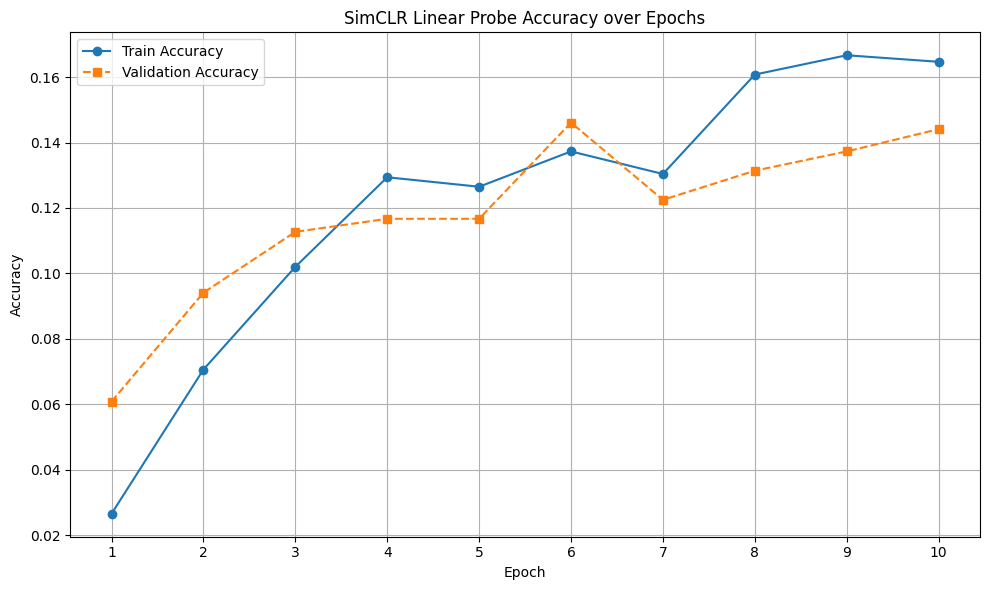

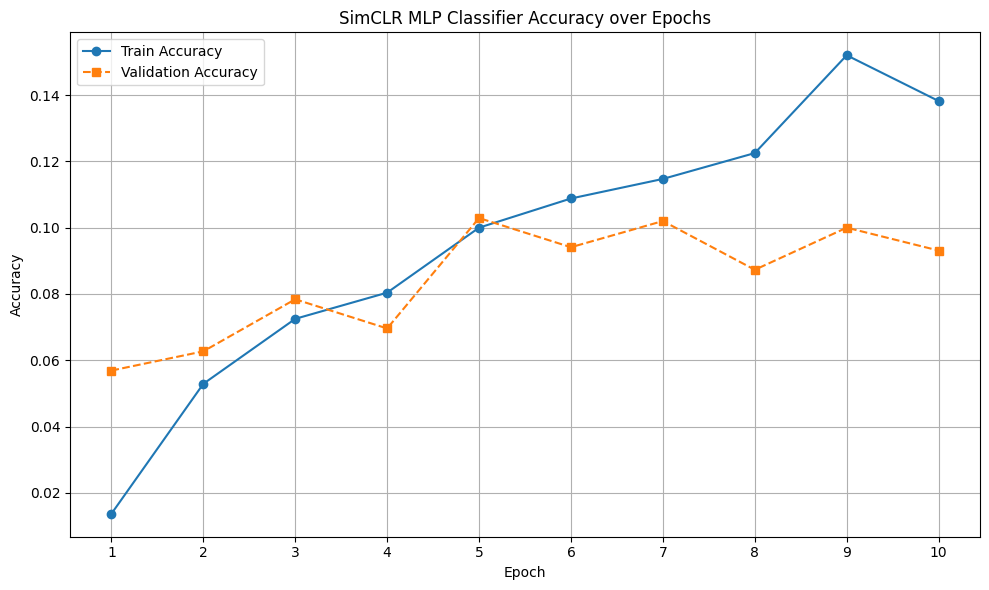

In [16]:
epochs = list(range(1, 11))

linear_train_acc = [0.0265, 0.0706, 0.1020, 0.1294, 0.1265, 0.1373, 0.1304, 0.1608, 0.1667, 0.1647]
linear_val_acc   = [0.0608, 0.0941, 0.1127, 0.1167, 0.1167, 0.1461, 0.1225, 0.1314, 0.1373, 0.1441]

mlp_train_acc = [0.0137, 0.0529, 0.0725, 0.0804, 0.1000, 0.1088, 0.1147, 0.1225, 0.1520, 0.1382]
mlp_val_acc   = [0.0569, 0.0627, 0.0784, 0.0696, 0.1029, 0.0941, 0.1020, 0.0873, 0.1000, 0.0931]

plt.figure(figsize=(10, 6))
plt.plot(epochs, linear_train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, linear_val_acc, label='Validation Accuracy', marker='s', linestyle='--')
plt.title('SimCLR Linear Probe Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epochs, mlp_train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, mlp_val_acc, label='Validation Accuracy', marker='s', linestyle='--')
plt.title('SimCLR MLP Classifier Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Method 2: Masked Autoencoder (MAE with Vision Transformer)

In summary, MAE masks a large portion of image patches and learns to reconstruct the missing patches from the visible ones. The encoder is a Vision Transformer, with a lightweight transformer decoder.

In [1]:
%pip install timm
%pip install scipy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [21]:

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import Flowers102
from torchvision import transforms
import timm
import argparse

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Loading
def get_data_loaders(batch_size=64):
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
    train_dataset = Flowers102(root="./data", split="train", transform=transform, download=True)
    val_dataset = Flowers102(root="./data", split="val", transform=transform, download=True)
    test_dataset = Flowers102(root="./data", split="test", transform=transform, download=True)

    from torch.utils.data import ConcatDataset
    # Why combine train and val?
    # 1. small size of training set
    # 2. We are not tunning hyperparameters for this model; our goal is probing representation quality
    train_dataset = ConcatDataset([train_dataset, val_dataset])
    print("size of training set: ", len(train_dataset))
    print("size of test set: ", len(test_dataset))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader, len(set(train_dataset.datasets[0]._labels))

# MAE-based ViT Encoder using pretrained weights from timm
def get_mae_encoder():
    encoder = timm.create_model("vit_base_patch16_224.mae", pretrained=True)
    encoder.head = nn.Identity()  # Remove classification head to use encoder only
    encoder.eval()
    return encoder

# Probes
class LinearProbe(nn.Module):
    def __init__(self, encoder, feature_dim, num_classes):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        with torch.no_grad():
            x = self.encoder(x)
        return self.classifier(x)

class MLPProbe(nn.Module):
    def __init__(self, encoder, feature_dim, num_classes):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        with torch.no_grad():
            x = self.encoder(x)
        return self.classifier(x)

# Training
def train_probe(model, train_loader, test_loader, num_epochs=10):
    def eval_probe(model, at_epoch: int):
        # Evaluation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                predicted = torch.argmax(outputs, dim=1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        print(f"\n----------At epoch {at_epoch}-------------")
        print(f"Test Accuracy: {100 * correct / total:.2f}%")
        print(f"\n------------------------------------------\n\n")
        

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")
        if ((epoch + 1) % 10) == 0 and epoch != 0:
            eval_probe(model, epoch)




# Main
def main(probe_type="linear", epochs=10):
    train_loader, test_loader, num_classes = get_data_loaders()
    encoder = get_mae_encoder()
    feature_dim = encoder.num_features

    if probe_type == "linear":
        model = LinearProbe(encoder, feature_dim, num_classes)
    else:
        model = MLPProbe(encoder, feature_dim, num_classes)

    train_probe(model, train_loader, test_loader, num_epochs=epochs)

In [10]:
linear_model = main("linear", 10)

size of training set:  2040
size of test set:  6149
Epoch 1/10, Loss: 4.6814
Epoch 2/10, Loss: 4.6382
Epoch 3/10, Loss: 4.6057
Epoch 4/10, Loss: 4.5763
Epoch 5/10, Loss: 4.5499
Epoch 6/10, Loss: 4.5255
Epoch 7/10, Loss: 4.5018
Epoch 8/10, Loss: 4.4788
Epoch 9/10, Loss: 4.4562
Epoch 10/10, Loss: 4.4346
Test Accuracy: 20.25%


In [11]:
mlp_model = main("mlp", 10)

size of training set:  2040
size of test set:  6149


Epoch 1/10, Loss: 4.6287
Epoch 2/10, Loss: 4.5946
Epoch 3/10, Loss: 4.5617
Epoch 4/10, Loss: 4.5244
Epoch 5/10, Loss: 4.4809
Epoch 6/10, Loss: 4.4322
Epoch 7/10, Loss: 4.3794
Epoch 8/10, Loss: 4.3218
Epoch 9/10, Loss: 4.2625
Epoch 10/10, Loss: 4.1997
Test Accuracy: 21.63%


In [24]:
linear_model = main("linear", 100)

size of training set:  2040
size of test set:  6149
Epoch 1/100, Loss: 4.6817
Epoch 2/100, Loss: 4.6355
Epoch 3/100, Loss: 4.5991
Epoch 4/100, Loss: 4.5686
Epoch 5/100, Loss: 4.5411
Epoch 6/100, Loss: 4.5162
Epoch 7/100, Loss: 4.4919
Epoch 8/100, Loss: 4.4689
Epoch 9/100, Loss: 4.4464
Epoch 10/100, Loss: 4.4250
Epoch 11/100, Loss: 4.4034

----------At epoch 10-------------
Test Accuracy: 22.08%

------------------------------------------


Epoch 12/100, Loss: 4.3824
Epoch 13/100, Loss: 4.3616
Epoch 14/100, Loss: 4.3407
Epoch 15/100, Loss: 4.3205
Epoch 16/100, Loss: 4.3007
Epoch 17/100, Loss: 4.2806
Epoch 18/100, Loss: 4.2606
Epoch 19/100, Loss: 4.2407
Epoch 20/100, Loss: 4.2209
Epoch 21/100, Loss: 4.2019

----------At epoch 20-------------
Test Accuracy: 36.77%

------------------------------------------


Epoch 22/100, Loss: 4.1825
Epoch 23/100, Loss: 4.1635
Epoch 24/100, Loss: 4.1443
Epoch 25/100, Loss: 4.1257
Epoch 26/100, Loss: 4.1067
Epoch 27/100, Loss: 4.0885
Epoch 28/100, Loss: 

In [25]:
mlp_model = main("mlp", 100)

size of training set:  2040
size of test set:  6149
Epoch 1/100, Loss: 4.6281
Epoch 2/100, Loss: 4.5930
Epoch 3/100, Loss: 4.5592
Epoch 4/100, Loss: 4.5199
Epoch 5/100, Loss: 4.4748
Epoch 6/100, Loss: 4.4245
Epoch 7/100, Loss: 4.3697
Epoch 8/100, Loss: 4.3126
Epoch 9/100, Loss: 4.2499
Epoch 10/100, Loss: 4.1853
Epoch 11/100, Loss: 4.1211

----------At epoch 10-------------
Test Accuracy: 18.77%

------------------------------------------


Epoch 12/100, Loss: 4.0543
Epoch 13/100, Loss: 3.9879
Epoch 14/100, Loss: 3.9226
Epoch 15/100, Loss: 3.8584
Epoch 16/100, Loss: 3.7943
Epoch 17/100, Loss: 3.7317
Epoch 18/100, Loss: 3.6714
Epoch 19/100, Loss: 3.6105
Epoch 20/100, Loss: 3.5537
Epoch 21/100, Loss: 3.4969

----------At epoch 20-------------
Test Accuracy: 27.32%

------------------------------------------


Epoch 22/100, Loss: 3.4383
Epoch 23/100, Loss: 3.3839
Epoch 24/100, Loss: 3.3325
Epoch 25/100, Loss: 3.2801
Epoch 26/100, Loss: 3.2310
Epoch 27/100, Loss: 3.1819
Epoch 28/100, Loss: 

The above sections try to train the classifer solely. Below, train both encoder and classifier together

In [26]:

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import Flowers102
from torchvision import transforms
import timm
import argparse

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Loading
def get_data_loaders(batch_size=64):
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
    train_dataset = Flowers102(root="./data", split="train", transform=transform, download=True)
    val_dataset = Flowers102(root="./data", split="val", transform=transform, download=True)
    test_dataset = Flowers102(root="./data", split="test", transform=transform, download=True)

    from torch.utils.data import ConcatDataset
    # Why combine train and val?
    # 1. small size of training set
    # 2. We are not tunning hyperparameters for this model; our goal is probing representation quality
    train_dataset = ConcatDataset([train_dataset, val_dataset])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader, len(set(train_dataset.datasets[0]._labels))

# MAE-based ViT Encoder using pretrained weights from timm
def get_mae_encoder():
    encoder = timm.create_model("vit_base_patch16_224.mae", pretrained=True)
    encoder.head = nn.Identity()  # Remove classification head to use encoder only
    encoder.train()
    return encoder

# Probes
class LinearProbe(nn.Module):
    def __init__(self, encoder, feature_dim, num_classes):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        x = self.encoder(x)
        return self.classifier(x)

class MLPProbe(nn.Module):
    def __init__(self, encoder, feature_dim, num_classes):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.classifier(x)

# Training
def train_probe(model, train_loader, test_loader, num_epochs=10):
    def eval_probe(model, at_epoch: int):
            # Evaluation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                predicted = torch.argmax(outputs, dim=1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        print(f"\n----------At epoch {at_epoch}-------------")
        print(f"Test Accuracy: {100 * correct / total:.2f}%")
        print(f"\n------------------------------------------\n\n")

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-3)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")
        if ((epoch + 1) % 10 == 0) and epoch != 0:
            eval_probe(model, epoch + 1)

# Main
def main(probe_type="linear", epochs=10):
    train_loader, test_loader, num_classes = get_data_loaders()
    encoder = get_mae_encoder()
    feature_dim = encoder.num_features

    if probe_type == "linear":
        model = LinearProbe(encoder, feature_dim, num_classes)
    else:
        model = MLPProbe(encoder, feature_dim, num_classes)

    train_probe(model, train_loader, test_loader, num_epochs=epochs)

In [29]:
linear_model = main("linear", 100)

Epoch 1/100, Loss: 4.6002
Epoch 2/100, Loss: 4.3484
Epoch 3/100, Loss: 4.1574
Epoch 4/100, Loss: 3.9755
Epoch 5/100, Loss: 3.8144
Epoch 6/100, Loss: 3.6604
Epoch 7/100, Loss: 3.5150
Epoch 8/100, Loss: 3.3813
Epoch 9/100, Loss: 3.2614
Epoch 10/100, Loss: 3.1425

----------At epoch 10-------------
Test Accuracy: 55.70%

------------------------------------------


Epoch 11/100, Loss: 3.0350
Epoch 12/100, Loss: 2.9339
Epoch 13/100, Loss: 2.8374
Epoch 14/100, Loss: 2.7456
Epoch 15/100, Loss: 2.6621
Epoch 16/100, Loss: 2.5775
Epoch 17/100, Loss: 2.5010
Epoch 18/100, Loss: 2.4271
Epoch 19/100, Loss: 2.3574
Epoch 20/100, Loss: 2.2930

----------At epoch 20-------------
Test Accuracy: 62.03%

------------------------------------------


Epoch 21/100, Loss: 2.2281
Epoch 22/100, Loss: 2.1697
Epoch 23/100, Loss: 2.1123
Epoch 24/100, Loss: 2.0592
Epoch 25/100, Loss: 2.0081
Epoch 26/100, Loss: 1.9559
Epoch 27/100, Loss: 1.9083
Epoch 28/100, Loss: 1.8653
Epoch 29/100, Loss: 1.8184
Epoch 30/100, Loss

In [30]:
mlp_model = main("mlp", 100)

Epoch 1/100, Loss: 4.5673
Epoch 2/100, Loss: 4.1920
Epoch 3/100, Loss: 3.7355
Epoch 4/100, Loss: 3.3093
Epoch 5/100, Loss: 2.9592
Epoch 6/100, Loss: 2.6730
Epoch 7/100, Loss: 2.4268
Epoch 8/100, Loss: 2.2041
Epoch 9/100, Loss: 2.0328
Epoch 10/100, Loss: 1.8593

----------At epoch 10-------------
Test Accuracy: 48.71%

------------------------------------------


Epoch 11/100, Loss: 1.7107
Epoch 12/100, Loss: 1.5753
Epoch 13/100, Loss: 1.4717
Epoch 14/100, Loss: 1.3765
Epoch 15/100, Loss: 1.2868
Epoch 16/100, Loss: 1.2018
Epoch 17/100, Loss: 1.1266
Epoch 18/100, Loss: 1.0640
Epoch 19/100, Loss: 0.9991
Epoch 20/100, Loss: 0.9440

----------At epoch 20-------------
Test Accuracy: 62.48%

------------------------------------------


Epoch 21/100, Loss: 0.8962
Epoch 22/100, Loss: 0.8549
Epoch 23/100, Loss: 0.7974
Epoch 24/100, Loss: 0.7521
Epoch 25/100, Loss: 0.7150
Epoch 26/100, Loss: 0.6880
Epoch 27/100, Loss: 0.6544
Epoch 28/100, Loss: 0.6124
Epoch 29/100, Loss: 0.5915
Epoch 30/100, Loss